# Gabriele Calarota


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
NUM_AUTHORS = 50
N_DOCS = 100
N_THRESHOLD = None
USE_BOW=False
USE_TFIDF=True
USE_W2V=False
OPEN_SET = True
OPEN_SET_NUM_AUTHORS=5
PROJECT_NAME = "RCV1"
DATASET_FILENAME = 'Reuteurs/RCV1/rcv1_ccat_parsed_renamed.csv'

In [3]:
!pip install -q tpot

     |████████████████████████████████| 92kB 6.1MB/s 
     |████████████████████████████████| 163kB 14.3MB/s 
     |████████████████████████████████| 157.5MB 104kB/s 


In [4]:
import os
import re
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
%matplotlib inline

from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn import preprocessing, decomposition, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.decomposition import KernelPCA, PCA
from keras.layers import GlobalAvgPool1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, AveragePooling1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras import backend as K
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import tarfile
import zipfile
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFwe, f_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVC
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, classification_report

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
base_dir = '/content/drive/Shared drives/Tesi_AuthorshipAttribution_Calarota/Dataset/'
#base_dir = ""

In [6]:
def print_stats_dataset(dataframe):
  num_text_total = len(dataframe)
  df_group_by_author = dataframe.groupby('author')
  df_count = df_group_by_author['articles'].count()
  num_of_authors = df_group_by_author.size().reset_index(name='counts').count()
  num_text_per_author_mean=df_group_by_author['articles'].count().mean()
  text_length_per_author=df_group_by_author['articles'].apply(lambda x: np.mean(x.str.len())).reset_index(name='mean_len_text')
  print(f"Numero di testi totale: {num_text_total}")
  print(f"Numero di testi per autore in media: {num_text_per_author_mean}")
  print(f"Numero di autori: {num_of_authors['author']}")
  print(f"Lunghezza media testo per autore in media: {text_length_per_author['mean_len_text'].mean()}")

In [7]:
dataset = pd.read_csv(os.path.join(base_dir, DATASET_FILENAME)) 
dataset.head()

,Unnamed: 0,articles,author
0,1,Chrysler Corp. Tuesday announced $380 million ...,David Lawder
1,2,CompuServe Corp. Tuesday reported a surprising...,Susan Zimmerman
2,3,CompuServe Corp. Tuesday reported a surprising...,Susan Zimmerman
3,7,Sprint Corp. Tuesday announced plans to offer ...,Susan Nadeau
4,9,Kansas and Arizona filed lawsuits against some...,Greg Frost


In [8]:
print_stats_dataset(dataset)

Numero di testi totale: 35667
Numero di testi per autore in media: 23.403543307086615
Numero di autori: 1524
Lunghezza media testo per autore in media: 3056.149551256315


In [9]:
def get_top_ten_authors(dataframe, number_prune=10):
  df_group_by_author = dataframe.groupby('author')
  df_count = df_group_by_author['articles'].count()
  num_of_authors = df_group_by_author.size().reset_index(name='counts')
  sorted_authors = num_of_authors.sort_values(by='counts', ascending=False)
  id_of_author = sorted_authors['author'].to_list()[:number_prune]
  return id_of_author

list_of_top_ten_authors = get_top_ten_authors(dataset, number_prune=NUM_AUTHORS)
dataset = dataset[dataset.author.isin(list_of_top_ten_authors)]
print_stats_dataset(dataset)

Numero di testi totale: 8978
Numero di testi per autore in media: 179.56
Numero di autori: 50
Lunghezza media testo per autore in media: 3208.73313196705


In [10]:
def get_only_n_docs_for_authors(dataframe, n_docs=200, threshold_document_length=600):
  if threshold_document_length is not None:
    dataframe = dataframe[dataframe.articles.str.len() > threshold_document_length]
  if n_docs is not None:
    dataframe = dataframe.groupby('author').head(n_docs).reset_index(drop=True)
  return dataframe
dataset = get_only_n_docs_for_authors(dataset, n_docs=N_DOCS, threshold_document_length=N_THRESHOLD)
print_stats_dataset(dataset)

Numero di testi totale: 5000
Numero di testi per autore in media: 100.0
Numero di autori: 50
Lunghezza media testo per autore in media: 3162.113600000001


In [11]:
dataset.head()

,Unnamed: 0,articles,author
0,1,Chrysler Corp. Tuesday announced $380 million ...,David Lawder
1,10,The higher minimum wage signed into law Tuesda...,Patricia Commins
2,27,The two main unions representing German retail...,Catherine O'Mahony
3,30,German utility group Viag AG on Tuesday said i...,Catherine O'Mahony
4,42,Talks between German retail workers' unions an...,Catherine O'Mahony


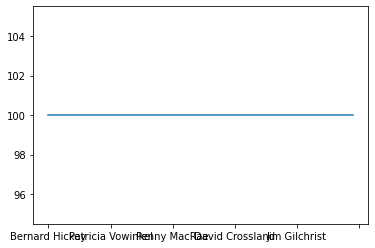

In [12]:
dataset['author'].value_counts().plot()

Train and test data are similarly distributed. An article can be attributed to an author based on the topic and content of the article or the author writing style or mix of both. In my basic approach, I will try to solve the problem by leveraging the frequency of words in the article, which represents the topic of an article. For this, I will construct a TF-IDF matrix. I am not going to rely on the default tokenizer provided by the scikit learn; I will create one for myself. The custom tokenizer involved three steps:

* Tokenize the article into sentences and sentences into words
* Filter the tokens with smaller lengths (assuming smaller words doesn't really say anything about the topic), whether a word is stop word or not, and whether the word is present in the dictionary or not
* Stem the words 

I am also going to construct a raw counts matrix as some models like MultinomialNB often perform better on raw counts

In [13]:
def tokenize_and_stem(text):
    """
    Below function tokenizes and lemmatizes the texts. It also does some cleaning by removing non dictionary words
    This can be used to replace default tokenizer provided by feature extraction api of sklearn.
    :param text: str
    :return: list
    """
    stemmer = SnowballStemmer("english")
    stop_words = stopwords.words("english")
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search(r'[a-zA-Z-]{4,}', token) and token not in stop_words and len(wn.synsets(token)) > 0:
            token.strip()
            filtered_tokens.append(token)
    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return filtered_tokens
  
def simple_tokenizer(text):
    text = re.sub('"([^"]*)"', '', text)
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if len(wn.synsets(token)) > 0:
            token.strip()
            filtered_tokens.append(token)
    return filtered_tokens

# custom_tokenizer = tokenize_and_stem
custom_tokenizer = simple_tokenizer

In [14]:
tfidf_vec = TfidfVectorizer(max_df=0.75, max_features=None,
                            min_df=0.02, use_idf=False, tokenizer=custom_tokenizer, ngram_range=(1, 2))
counter_vect = CountVectorizer(max_df=0.8, max_features=10000,
                               min_df=0.02, tokenizer=custom_tokenizer, ngram_range=(1, 2))

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
# Even split 50 & 50 per author and document
df_train = dataset.groupby('author').head(N_DOCS/2).reset_index(drop=True)
if OPEN_SET:
  df_train = df_train[df_train.groupby('author').ngroup() < (NUM_AUTHORS-OPEN_SET_NUM_AUTHORS)]
print_stats_dataset(df_train)
df_train.head()

Numero di testi totale: 2250
Numero di testi per autore in media: 50.0
Numero di autori: 45
Lunghezza media testo per autore in media: 3119.268444444445


,Unnamed: 0,articles,author
0,1,Chrysler Corp. Tuesday announced $380 million ...,David Lawder
1,10,The higher minimum wage signed into law Tuesda...,Patricia Commins
2,27,The two main unions representing German retail...,Catherine O'Mahony
3,30,German utility group Viag AG on Tuesday said i...,Catherine O'Mahony
4,42,Talks between German retail workers' unions an...,Catherine O'Mahony


In [17]:
# get difference between dataset and df_train for df_test
df_test = pd.concat([dataset,df_train]).drop_duplicates(keep=False)
print_stats_dataset(df_test)
df_test.head()

Numero di testi totale: 2750
Numero di testi per autore in media: 55.0
Numero di autori: 50
Lunghezza media testo per autore in media: 3192.933000000001


,Unnamed: 0,articles,author
26,2632,German steel and engineering group Fried. Krup...,William Boston
29,2780,"At Home Corp., which is developing technology ...",Therese Poletti
36,3185,As America Online continues to dominate the on...,Therese Poletti
46,4615,German steel and engineering group Fried. Krup...,William Boston
58,5459,As America Online Inc. continues to dominate t...,Therese Poletti


## => Extracting features

In [18]:
def tfidf_fit_transform():
  # df_train, df_test = train_test_split(dataset, test_size=0.5, random_state=0)
  tfidf_train = tfidf_vec.fit_transform(df_train['articles'])
  tfidf_test = tfidf_vec.transform(df_test['articles'])
  return tfidf_train, tfidf_test

def counter_fit_transform():
  counter_train = counter_vect.fit_transform(df_train['articles'])
  counter_test = counter_vect.transform(df_test['articles'])
  return counter_train, counter_test

In [19]:
le = LabelEncoder()
df_train['target'] = le.fit_transform(df_train['author'])
df_test['author'] = df_test['author'].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
df_test['target']  = le.transform(df_test['author'])


While above models tried to use the classify the articles based on the words and their frequencies, I will try to build a sequence model that tries to capture the writing style of an author. However, I am dubious about the effectiveness of these models considering the limited amount of data.

I will change the tokenizer by removing stem as I am going to replace words with Glove embeddings that provide relevant words vectors to all verb forms of a word. Below are the changes that I will make:

Remove words in the quotes as they don't contribute to capture the writing style of the author.
Not stemming the words to replace the words with corresponsing Glove vectors
Not removing stop words, as some authors whose articles aren't published online may not hesitate to use lot of stop words



In [20]:
def build_custom_w2v_model():
  import numpy as np
  import keras.backend as K
  from keras.models import Sequential
  from keras.layers import Dense, Embedding, Lambda
  from keras.utils import np_utils
  from keras.preprocessing import sequence
  from keras.preprocessing.text import Tokenizer
  import gensim
  vectorize = Tokenizer()
  vectorize.fit_on_texts(dataset['articles'])
  data = vectorize.texts_to_sequences(dataset['articles'])
  total_vocab = sum(len(s) for s in data)
  word_count = len(vectorize.word_index) + 1
  window_size = 2
  print(f"total vocab: {total_vocab}")
  print(f"word count: {word_count}")

  def cbow_model(data, window_size, total_vocab):
      total_length = window_size*2
      for text in data:
          text_len = len(text)
          for idx, word in enumerate(text):
              context_word = []
              target   = []            
              begin = idx - window_size
              end = idx + window_size + 1
              context_word.append([text[i] for i in range(begin, end) if 0 <= i < text_len and i != idx])
              target.append(word)
              contextual = sequence.pad_sequences(context_word, maxlen=total_length)
              final_target = np_utils.to_categorical(target, total_vocab)
              yield(contextual, final_target) 

  model = Sequential()
  model.add(Embedding(input_dim=total_vocab, output_dim=100, input_length=window_size*2))
  model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(100,)))
  model.add(Dense(total_vocab, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  for i in range(10):
      cost = 0
      for contextual, final_target in cbow_model(data, window_size, total_vocab):
          cost += model.train_on_batch(contextual, final_target)
      print(i, cost)
  dimensions=100
  vect_file = open(os.path.join(os.path.dirname(os.path.join(base_dir, DATASET_FILENAME)), 'vectors.txt') ,'w')
  vect_file.write('{} {}\n'.format(total_vocab,dimensions))
  weights = model.get_weights()[0]
  for text, i in vectorize.word_index.items():
      final_vec = ' '.join(map(str, list(weights[i, :])))
      vect_file.write('{} {}\n'.format(text, final_vec))
  vect_file.close()

if USE_W2V and not os.path.exists(os.path.join(os.path.dirname(os.path.join(base_dir, DATASET_FILENAME)), 'vectors.txt')):
  build_custom_w2v_model()

In [21]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

def w2v_fit_transform():
  USE_GLOVE = False
  if USE_GLOVE:
    glove_path = os.path.join(base_dir, 'glove.6B.50d.txt')
    word2vec_output_file = glove_path+'.word2vec'
    if not os.path.exists(word2vec_output_file):
      glove2word2vec(glove_path, word2vec_output_file)
  else:
    word2vec_output_file = os.path.join(os.path.dirname(
        os.path.join(base_dir, DATASET_FILENAME)), 'vectors.txt')
  model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

  # Set a word vectorizer
  vectorizer = Word2VecVectorizer(model)
  # Get the sentence embeddings for the train dataset
  w2v_train = vectorizer.fit_transform(df_train['articles'])
  # Get the sentence embeddings for the test dataset
  w2v_test = vectorizer.transform(df_test['articles'])
  print(w2v_train.shape,w2v_test.shape)
  return w2v_train, w2v_test

In [22]:
def teapot_search():
  from tpot import TPOTClassifier, TPOTRegressor
  #tpot_settings = dict(verbosity=2, random_state = 1234, scoring = 'accuracy', warm_start = True, config_dict='TPOT sparse')
  #auto_reg = TPOTRegressor(generations=2, population_size=5, **tpot_settings)
  #auto_reg.fit(tfidf_train, df_train['target'])
  #print(auto_reg.score(tfidf_test, df_test['target']))
  #auto_reg.export('tpot_exported_pipeline.py')
  #pipeline_optimizer = TPOTClassifier()
  pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                      random_state=42, verbosity=2, scoring='accuracy', config_dict='TPOT sparse')
  pipeline_optimizer.fit(tfidf_train, df_train['target'])
  print(pipeline_optimizer.score(tfidf_test, df_test['target']))
  pipeline_optimizer.export('tpot_exported_pipeline.py')

In [23]:
def use_features(tfidf=False, bow=False, w2v=False):
  if tfidf:
    return tfidf_fit_transform()
  elif bow:
    return counter_fit_transform()
  elif w2v:
    return w2v_fit_transform()
  else:
    return tfidf_train, tfidf_test

training_features, testing_features = use_features(tfidf=USE_TFIDF, bow=USE_BOW, w2v=USE_W2V)
training_target = df_train['target']
testing_target = df_test['target']
print(training_target)
print(testing_target)
training_features

0        9
1       36
2        5
3        5
4        5
        ..
2495    10
2496    10
2497    10
2498    10
2499    10
Name: target, Length: 2250, dtype: int64
26      45
29      45
36      45
46      45
58      45
        ..
4995    34
4996    34
4997    34
4998    34
4999    34
Name: target, Length: 2750, dtype: int64


<2250x2527 sparse matrix of type '<class 'numpy.float64'>'
	with 370970 stored elements in Compressed Sparse Row format>

In [24]:
training_features

<2250x2527 sparse matrix of type '<class 'numpy.float64'>'
	with 370970 stored elements in Compressed Sparse Row format>

In [25]:
def double_pipeline():
  # Average CV score on the training set was: 0.9173333333333333
  exported_pipeline = make_pipeline(
      make_union(
          FunctionTransformer(copy),
          SelectFwe(score_func=f_classif, alpha=0.004)
      ),
      LinearSVC(C=20.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.01)
  )
  # Fix random state for all the steps in exported pipeline
  set_param_recursive(exported_pipeline.steps, 'random_state', 42)
  return exported_pipeline

def single_pipeline():
  # Average CV score on the training set was: 0.6912
  exported_pipeline = LinearSVC(C=20.0, dual=True, loss="hinge", penalty="l2", tol=0.0001)
  # Fix random state in exported estimator
  if hasattr(exported_pipeline, 'random_state'):
      setattr(exported_pipeline, 'random_state', 42)
  return exported_pipeline

def onevsrestclassifier():
  from sklearn.multiclass import OneVsRestClassifier
  return OneVsRestClassifier(LinearSVC(C=20.0, dual=True, loss="hinge", penalty="l2", tol=0.0001, multi_class='ovr', random_state=42, max_iter=10000))

def onevsrestclassifier_combined():
  from sklearn.multiclass import OneVsRestClassifier
  exported_pipeline = make_pipeline(
      make_union(
          FunctionTransformer(copy),
          SelectFwe(score_func=f_classif, alpha=0.004)
      ),
      OneVsRestClassifier(LinearSVC(C=20.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.01))
  )
  # Fix random state for all the steps in exported pipeline
  set_param_recursive(exported_pipeline.steps, 'random_state', 42)
  return exported_pipeline

def one_class_classifier():
  from sklearn.svm import OneClassSVM
  return OneClassSVM()

def select_features_for_author(author_selected=1):
  training_features_new = np.array([])
  for index, author_id in enumerate(training_target):
      if author_id != author_selected:
        training_features_new = np.concatenate((training_features_new, training_features[index]))
  return training_features_new

def transform_testing_target(author_selected=1):
  testing_target_new = []
  for index, author_id in enumerate(testing_target):
      if author_id == author_selected:
        testing_target_new.append(1)
      else:
        testing_target_new.append(-1)
  return training_features_new

exported_pipeline = onevsrestclassifier()

In [26]:
exported_pipeline.fit(training_features, training_target)
predicted = exported_pipeline.predict(testing_features)

In [27]:
accuracy_result = accuracy_score(testing_target, predicted)
precision_result = precision_score(testing_target, predicted, average='macro')
recall_result = recall_score(testing_target, predicted, average='macro')
f1_result = f1_score(testing_target, predicted, average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(f"Accuracy: {accuracy_result}\nPrecision: {precision_result}\nRecall: {recall_result}\nF1_macro: {f1_result}")

Accuracy: 0.6305454545454545
Precision: 0.6427620459714135
Recall: 0.7539130434782608
F1_macro: 0.6845925641835892


In [29]:
print(classification_report(testing_target, predicted))

              precision    recall  f1-score   support

           0       0.57      0.86      0.69        50
           1       0.46      0.54      0.50        50
           2       0.78      0.86      0.82        50
           3       0.75      0.48      0.59        50
           4       0.56      0.74      0.64        50
           5       0.40      0.58      0.48        50
           6       0.94      0.90      0.92        50
           7       0.65      0.86      0.74        50
           8       0.51      0.74      0.61        50
           9       0.37      0.88      0.52        50
          10       0.76      0.88      0.81        50
          11       0.52      0.48      0.50        50
          12       0.53      0.66      0.59        50
          13       0.83      0.78      0.80        50
          14       0.98      0.96      0.97        50
          15       0.56      0.94      0.70        50
          16       0.69      0.70      0.69        50
          17       0.98    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
!pip install -q python-telegram-bot
from telegram import Bot
bot = Bot(token="627493222:AAE8dqAHnrx9JJ3AGxDwb-x2eiJqoXVBM8o")
bot.send_message(text="Training finito di OPEN_SET SVM {} on {} authors with {} ndocs and {} threshold".format(PROJECT_NAME, NUM_AUTHORS, N_DOCS, N_THRESHOLD), chat_id="141928344")

     |████████████████████████████████| 430kB 8.2MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 2.6MB 63.6MB/s 
